In [1]:
#install some necessary libraries
!pip install pandas sklearn xgboost

In [2]:
# import the libraries we'll need
import pandas as pd
import seaborn as sns
import numpy as np
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [3]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.Attack_Tag,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",LOG4J,NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

df['request.url'] =  df['request.url'].str.slice(22)
max_lengths = df.apply(lambda x: x.apply(str).str.len().max())
print(max_lengths)


request.headers.Host                            14
request.headers.User-Agent                     121
request.headers.Accept-Encoding                312
request.headers.Accept                           3
request.headers.Connection                      10
request.headers.Sec-Ch-Ua-Platform               9
request.headers.Sec-Ch-Ua-Mobile                 3
request.headers.Accept-Language                 23
request.headers.Sec-Fetch-Site                 377
request.headers.Sec-Fetch-Mode                  11
request.headers.Cache-Control                    9
request.headers.Sec-Fetch-User                   3
request.headers.Sec-Fetch-Dest                 665
request.headers.Set-Cookie                    2696
request.headers.Date                            29
request.method                                   4
request.url                                    239
request.body                                    41
response.status                                 25
response.headers.Content-Type  

In [5]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,orders/check/exists?val=8215,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,login/user?username=Richard&password=Uq3T8e7o4...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,LOG4J,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,states/Bagdon?resource=RX372IP5FlyRSI_mXxMOmSh...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,"en-US,en;q=0.5",none,websocket,no-cache,?1,document,['ttauth=NPpRHbzfv7BJ5RGB9-oJNl30Ttdc8RYxbuiSe...,"Sun, 18 Dec 2022 01:25:40 GMT",GET,login/user?username=Brueggeman&password=JonaBa...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,SQL Injection,Malware
182763,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,de-CH,none,websocket,no-cache,?1,document,['ttauth=Mqfe3PeeakWRmzjsA7MKaNiXmVcbMxMuNQxej...,"Sun, 18 Dec 2022 01:19:48 GMT",GET,cookielogin,,200 OK,text/html; charset=utf-8,104,200,text/html; charset=utf-8,NaN,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
182764,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,de-CH,none,same-origin,max-age=0,?1,document,['cid=-Sp8A62rcqJXADEypNzwtw-iIf9cdHkqMQvKTMNB...,"Sun, 18 Dec 2022 01:31:12 GMT",GET,forum,,200 OK,text/html; charset=utf-8,12821

In [6]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",None,None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,orders/check/exists?val=8215,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,None,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,login/user?username=Richard&password=Uq3T8e7o4...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",None,None,None,None,None,LOG4J,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,None,None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,states/Bagdon?resource=RX372IP5FlyRSI_mXxMOmSh...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",None,None,None,None,None,Benign,Benign


In [7]:
df.head(2)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",None,None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,orders/check/exists?val=8215,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,None,Benign,Benign


In [8]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Accept',
                'request.headers.Accept-Language',
                'request.headers.Date',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'response.headers.Location',
                'request.headers.Set-Cookie',
                'request.method',
                'request.url',
                'response.status',
                'response.body',
                'request.headers.Content-Length',
                'request.headers.Cookie',
                'response.headers.Set-Cookie',
                'response.headers.Content-Length',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [

                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'request.headers.Host',
                    'request.headers.Date',
                    'request.headers.Sec-Fetch-User',
                    'response.headers.Content-Type',
                    'request.headers.User-Agent',
                    'request.headers.Connection'
                    ]

CTOR2 = [   'request.headers.Cache-Control',
            'request.headers.Sec-Ch-Ua-Mobile',
            'request.headers.Upgrade-Insecure-Requests',
            'request.headers.Sec-Ch-Ua-Platform']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    
    for column in CTOR2: 
        df[column] = le.fit_transform(df[column])
    
    return df

df = vectorize_df(df)
df.head()

,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,1,0,0,0,2,1,1,3,1,112176,0,75190,0,3902,200,258,2,0,29,0,1,Benign,Benign
1,1,0,0,0,4,1,2,2,1,8413,0,63097,5,2585,404,9586,2,0,29,0,1,Benign,Benign
2,181,0,1,1,4,1,1,3,1,130505,0,52341,4,2432,401,2861,2,0,29,0,1,LOG4J,Malware
3,637,0,0,1,4,1,2,2,1,141830,0,37500,0,2315,200,260,2,0,29,0,1,Benign,Benign
4,1,0,0,1,2,1,2,1,1,147511,0,75448,5,2497,404,9588,2,0,29,0,1,Benign,Benign


In [9]:
features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

# features_list = ['request.url', 'response.status_code', 'response.status', 'request.headers.User-Agent', 'response.headers.Content-Type', 'request.method', 'request.headers.Content-Length', 'response.headers.Content-Length']

print(features_list)

['request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Cache-Control', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'request.headers.Upgrade-Insecure-Requests']


In [10]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 21) (150508,)
(32259, 21) (32259,)


Counter({'Benign': 143297, 'Malware': 39470})

In [11]:
# Convert the labels to integers
y_train = [1 if y == "Malware" else 0 for y in y_train]
y_test = [1 if y == "Malware" else 0 for y in y_test]

In [12]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, reg_lambda=1)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
# evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 0.99


              precision    recall  f1-score   support

           0    0.98681   1.00000   0.99336     25292
           1    1.00000   0.95149   0.97514      6967

    accuracy                        0.98952     32259
   macro avg    0.99341   0.97574   0.98425     32259
weighted avg    0.98966   0.98952   0.98943     32259



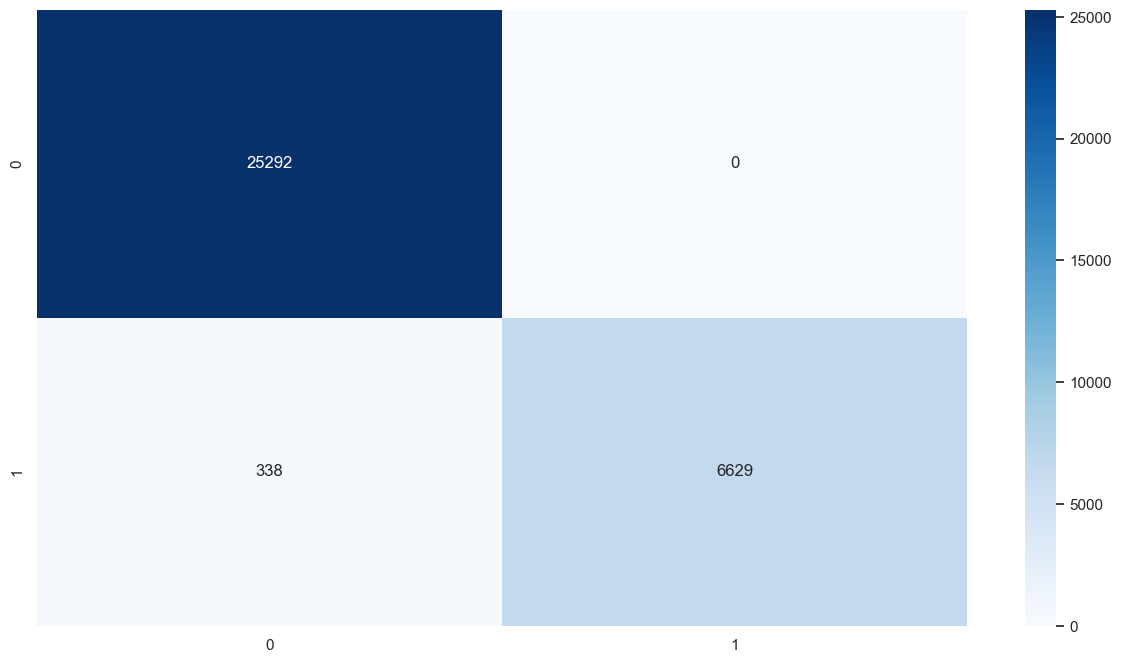

In [14]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = model.predict(X_test)
true_labels = y_test
model_matrix = confusion_matrix(true_labels, predictions)
model_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(model_report)

In [15]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

for column in test_df.columns[test_df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = model.predict(X)

In [16]:
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')